# Psytrack Tutorial

Link to paper: http://pillowlab.princeton.edu/pubs/Roy18_NeurIPS_dynamicPsychophys.pdf

Last updated: February 16, 2020

Psytrack version: 1.2.0

---

### Initialization

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 140

import psytrack as psy

# Quick Demonstration

This is a quick, 2 minute _demonstration_ of Psytrack with a simulated dataset.

\*\* **Please find a much more in-depth tutorial using real data below** \*\*

---

### Generate simulated data

This includes generating psychometric weights ${\bf w}$, as well as the inputs ${\bf x}$ (sampled from a standard normal) and choices ${\bf y}$ (sampled according to the model using the weights and inputs).

(-3.6, 3.6)

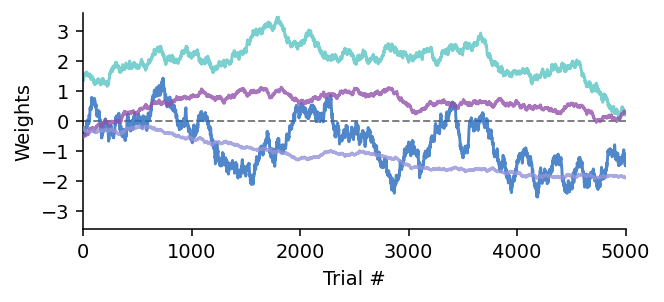

In [5]:
seed = 31
num_weights = 4
num_trials = 5000
# Prior sigma (?) or not?
hyper = {'sigma'   : 2**np.array([-4.0,-5.0,-6.0,-7.0]), #
         'sigInit' : 2**np.array([ 0.0, 0.0, 0.0, 0.0])}

# Simulate
simData = psy.generateSim(K=num_weights, N=num_trials, hyper=hyper,
                          boundary=6.0, iterations=1, seed=seed, savePath=None)

# Plot
psy.plot_weights(simData['W'].T)
plt.ylim(-3.6,3.6)

In [6]:
help(psy.generateSim)

Help on function generateSim in module psytrack.runSim:

generateSim(K=4, N=64000, hyper={}, days=None, boundary=4.0, iterations=20, seed=None, savePath=None)
    Simulates weights, inputs, and choices under the model.
    
    Args:
        K : int, number of weights to simulate
        N : int, number of trials to simulate
        hyper : dict, hyperparameters and initial values used to construct the
            prior. Default is none, can include sigma, sigInit, sigDay
        days : list or array, list of the trial indices on which to apply the
            sigDay hyperparameter instead of the sigma
        boundary : float, weights are reflected from this boundary
            during simulation, is a symmetric +/- boundary
        iterations : int, # of behavioral realizations to simulate,
            same input and weights can render different choice due
            to probabilistic model, iterations are saved in 'all_Y'
        seed : int, random seed to make random simulations re

In [4]:
# Sim Data in dic format
simData

{'sigInit': array([1., 1., 1., 1.]),
 'sigDay': None,
 'sigma': array([0.0625   , 0.03125  , 0.015625 , 0.0078125]),
 'dayLength': None,
 'seed': 31,
 'W': array([[-0.4343693 ,  1.34700479, -0.49779972, -0.2405024 ],
        [-0.43356056,  1.32084552, -0.49964051, -0.25749655],
        [-0.47947976,  1.34969436, -0.51976486, -0.25537572],
        ...,
        [-1.48016105,  0.33025206,  0.27561389, -1.8873101 ],
        [-1.42635657,  0.29754755,  0.28747175, -1.90199806],
        [-1.49545299,  0.2715588 ,  0.27901971, -1.90278552]]),
 'X': array([[-1.53838712,  0.42103903,  0.41645744, -0.68211591],
        [ 0.10428459, -1.51795415, -0.57449161, -0.05326662],
        [ 0.64070616,  2.27887192,  0.72229007, -0.66272997],
        ...,
        [ 0.26584933,  2.0332635 , -0.7496208 ,  0.47398381],
        [-0.17065255,  0.06548138,  0.50212868,  1.55632706],
        [ 1.20698087, -0.53682278, -0.60912088, -0.17290518]]),
 'K': 4,
 'N': 5000,
 'all_Y': [array([2, 1, 2, ..., 1, 1, 1])]}

### Recover the weights from the simulated behavior

That is, given inputs ${\bf x}$ and choices ${\bf y}$, recover the psychometric weights ${\bf w}$.

_Note: This takes approximately 60 seconds_

In [9]:
# Fit data!
rec = psy.recoverSim(simData)

In [8]:
help(psy.recoverSim)

Help on function recoverSim in module psytrack.runSim:

recoverSim(data, N=None, iteration=0, hess_calc='All', save=False)
    Recovers weights from the simulation data generated by generateSim().
    
    Can take in a filepath pointing to simulation data, or the simulation
    dict directly. Specify how many trials of data should be recovered, 
    and from which behavioral iteration (only one). Output is either saved
    in same folder as generated data, or returned directly.
    
    Args:
        data : str or dict, either the filepath to data from generateSim()
            or the dict returned directly by generateSim()
        N : int, number of trials to simulate, if None then just the 
            full length of the simulation
        iterations : int, which # of the behavioral realizations to recover
        hess_calc : str, passed to hyperOpt(), error bars to calculate
        save : bool, if True saves recovery data as a file in same folder
            as generateSim data (e

### Plot the true weights from above (now in black) with the recovered weights (in color)

Recovered weights also have shading to indicate a 95\% credible interval.

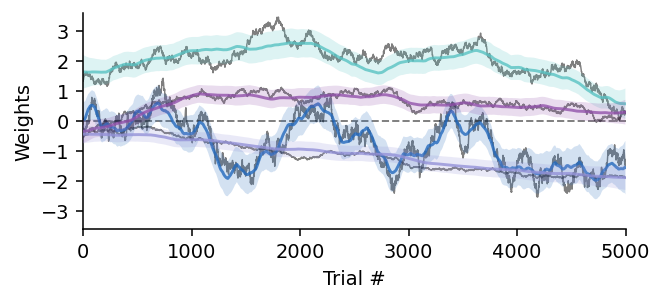

In [10]:
psy.plot_weights(rec['wMode'], errorbar=rec["hess_info"]["W_std"]) # can plot recovered mode of the weights, and std
plt.plot(simData['W'], c="k", ls="-", alpha=0.5, lw=0.75, zorder=0)
plt.ylim(-3.6,3.6);

### Plot recovered smoothness hyperparameters $\sigma_k$ over the true hyperparameters (black lines)

Recovered hyperparameters plotted with $\pm$2SE bars.

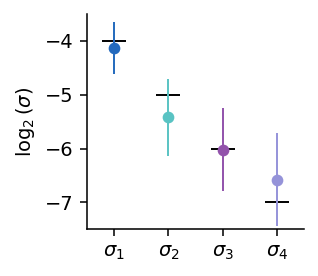

In [11]:
true_sigma = np.log2(rec['input']['sigma'])
avg_sigma = np.log2(rec['hyp']['sigma'])
err_sigma = rec['hess_info']['hyp_std']

plt.figure(figsize=(2,2))
colors = np.unique(list(psy.COLORS.values()))
for i in range(num_weights):
    plt.plot(i, true_sigma[i], color="black", marker="_", markersize=12, zorder=0)
    plt.errorbar([i], avg_sigma[i], yerr=2*err_sigma[i], color=colors[i], lw=1, marker='o', markersize=5)

plt.xticks([0,1,2,3]); plt.yticks(np.arange(-8,-2))
plt.gca().set_xticklabels([r"$\sigma_1$", r"$\sigma_2$", r"$\sigma_3$", r"$\sigma_4$"])
plt.xlim(-0.5,3.5); plt.ylim(-7.5,-3.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel(r"$\log_2(\sigma)$");

---

---

# Full Tutorial with Real Data

Datasets handled by Psytrack are specific to an individual animal and are stored as a Python dictionary

In [9]:
# Extract premade dataset from npz
D = np.load('sampleRatData.npz', allow_pickle=True)['D'].item()

print("The keys of the dict for this example animal:\n   ", list(D.keys()))

The keys of the dict for this example animal:
    ['name', 'y', 'answer', 'correct', 'dayLength', 'inputs']


Of these keys, only `y` and `inputs` are **required** for analysis of the dataset, all others are *optional*.

---

`y` should be a 1D array of the animal's choice on each trial. Currently, the analysis only works for two-alternative forced choice tasks, and so there should only be two options on each trial (error or omission trials are typically discarded from the analysis).

The two options (A or B, Left or Right, etc.)  must be mapped to {1, 2} _or_ {0, 1} in `y` (not -1 and +1). In this example, Left=1 and Right=2.

<span style="color:orange">__Question__:</span> Why 1 and 2? I thought we were doing a logistic? But there might be a offset


In [12]:
print("The shape of y:   ", D['y'].shape)
print("The number of trials:   N =", D['y'].shape[0])
print("The unique entries of y:   ", np.unique(D['y']))

The shape of y:    (20000,)
The number of trials:   N = 20000
The unique entries of y:    [1. 2.]


---

`inputs` is itself another dictionary, containing arbitrary keys. Each of these keys represents a _potential_ input into the model and must be a 2D array of shape $(N, M)$ where $N$ is the number of trials. The number of columns $M$ is arbitrary, and the $i^{th}$ column is typically used to encode information from $i$ time steps previous.

For example, in our example data set the key `s1` encodes the (normalized) stimulus values heard on each trial. `s1[7,0]` would encode the stimulus heard on the 7th trial where as both `s1[6,0]` and `s1[7,1]` would encode the stimulus heard on the 6th trial. The information is redundant, but allows for all feasible regressors to predicting behavior of trial $i$ to be accessible by referencing the $i^{th}$ row of the respective input array.

<span style="color:orange">__Question__:</span> I think I get it now, that it is the left signal history or the right signal history (?)



In [15]:
D['inputs'].keys()

dict_keys(['h', 'r', 'c', 's1', 's2', 's_avg'])

In [18]:
D['inputs']['h'].shape

(20000, 2)

In [14]:
print("The keys of inputs:\n   ", list(D['inputs'].keys()))

print("\nThe shape of s1:", D['inputs']['s1'].shape)
print("s1[7]   : ", D['inputs']['s1'][7])
print("s1[6,0] : ", D['inputs']['s1'][6,0])
print("s1[7,1] : ", D['inputs']['s1'][7,1])

The keys of inputs:
    ['h', 'r', 'c', 's1', 's2', 's_avg']

The shape of s1: (20000, 2)
s1[7]   :  [-0.04184135  0.73846325]
s1[6,0] :  0.738463248564285
s1[7,1] :  0.738463248564285


---

Other keys are for convenience and are _optional_ : `name` stores the name of the animal, `answer` is an easy reference as to what the correct choice was on a given trial, and `correct` is an easy reference as to whether the animal made the correct choice on a given trial. The model only needs to know what the animal _actually_ did, not what the animal _ought_ to have done!

`dayLength` is an array storing the number of trials that occurred in each session of training. Taking a cumulative sum will give you the indices at which each new session begins. This is **not** optional for the analysis if one wishes to use the `sigmaDay` functionality (see Section 3.3 in paper).

---

## Fitting the data

Once you have your data arranged in the proper format, you can now run the analysis! 

The fitting function is called `hyperOpt()` and before using it, you must decide on 3 inputs:

   1) `weights` : which of your inputs should you fit.

   2) `hyper` : what hyperparameters should your model have and how should they be initialized.

   3) `optList` : what subset of the hyperparameters should be optimized.

`weights` is a dictionary where the keys correspond to the keys in your dataset's `inputs` dictionary; the key values are a non-negative integer indicating how many of the columns of that value in `inputs` should be used for fitting the model, where each included column corresponds to a new weight. You can also include in `weights` the special key `bias` which need not be included in `inputs` --- this will simply create an input of all 1s.

In [21]:
weights = {'bias': 1,  # a special key
           's1': 1,    # use only the first column of s1 from inputs
           's2': 1}    # use only the first column of s2 from inputs

# It is often useful to have the total number of weights K in your model
K = np.sum([weights[i] for i in weights.keys()])

`hyper` is a dictionary that indicates what hyperparameters your model will have. There are 3 types:

1) `sigma` : required, controls trial-to-trial variability.

2) `sigInit` : optional, controls the variability on the very first trial (e.g. how close weights must initialize to 0). It is often best to include this hyperparameter and set it to a high value, as you often prefer your data to determine where the weights ought to initialize. Otherwise, `sigInit` will be set equal to `sigma`.

3) `sigDay` : optional, controls variability between sessions (e.g. between the last trial of one session and the first trial of the next session). If this key is included, then your dataset must also have the key `dayLength` (as described above), to indicate the trials where the `sigDay` variability should supercede the standard `sigma` variability.

For each hyperparameter key included in the `hyper` dictionary, the corresponding value is the initial value of the hyperparameter. If you are optimizing over a particular hyperparameter (see the `optList` setting below), than the initial value is not so important as the fitting procedure will eventually converge to the optimal setting. However, if you are *not* optimizing, then the initial value set will be the *fixed* value of the hyperparameter.

Finally, for each hyperparameter key in `hyper`, you must specify your initializations as a 1D array with length $K$. If you instead provide only a single value, then the optimizer will assume that you want the same hyperparameter to apply to every weight (as opposed to each weight having it's own).

In [23]:
hyper= {'sigInit': 2**4.,      # Set to a single, large value for all weights. Will not be optimized further.
        'sigma': [2**-4.]*K,   # Each weight will have it's own sigma optimized, but all are initialized the same
        'sigDay': None}        # Indicates that session boundaries will be ignored in the optimization

`optList` is a list of the subset of hyperparameters in `hyper` that you wish to optimize over in your model. It is typically unnecessary to optimize over `sigInit` -- a single, large, fixed value is usually best. Thus, there are 4 reasonable ways to specify `optList`:

1) `optList = []` : this means that none of the hyperparameters in `hyper` will be optimized. The optimizer will find the best set of weight trajectories given the fixed hyperparameter values specified.

2) `optList = ['sigma']` : only the `sigma` hyperparameter will be optimized (as we will do below). If `sigDay` is included in `hyper`, then this means that the model _will_ include `sigDay`, but that the initial value specified will not be optimized.

3) `optList = ['sigDay']` : only the `sigDay` hyperparameter will be optimized, while the `sigma` hyperparameter remains fixed.

4) `optList = ['sigma', 'sigDay']` : both the `sigma` and `sigDay` hyperparameters will be optimized.

In [24]:
optList = ['sigma']

Now that we have specified `weights`, `hyper`, and `optList`, we can fit our model with `hyperOpt()`! The function takes your dataset `D` plus the three additional inputs, and returns 4 things:

1) `hyp` : a dictionary of the optimized hyperparameters

2) `evd` : the approximate log-evidence of the optimized model

3) `wMode` : the weight trajectories of the optimized model

4) `hess_info` : a dictionary of sparse terms that relate to the Hessian of the optimal model. By default, this also includes the posterior credible intervals on the weights, under the key `W_std`. This behavior can be altered by changing the optional argument `hess_calc` in `hyperOpt()` (see function documentation for more details).

Run times will depend on the number of trials $N$ and weights $K$, as well as the number of hyperparameters being fit. To speed things up a bit, we will use the `trim` function to shrink our dataset of 20K trials to just the first 10K.

_Note: this should take < 60 seconds._

In [25]:
new_D = psy.trim(D, END=10000)  # trim dataset to first 10,000 trials

In [26]:
hyp, evd, wMode, hess_info = psy.hyperOpt(new_D, hyper, weights, optList)

---
### Visualizing the results

Psytrack includes a few plotting functions for visualizing the results of the fit. To see the weight trajectories, use `plot_weights`.

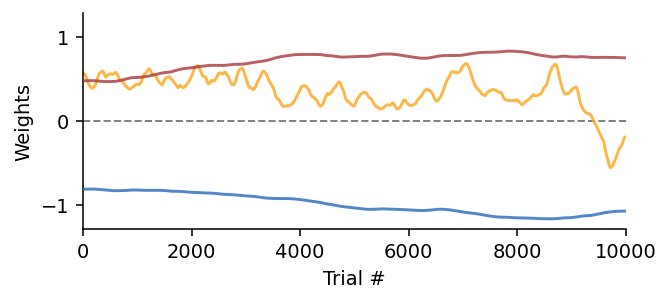

In [27]:
fig = psy.plot_weights(wMode, weights)

Adding credible intervals on the weights can be done with the `errorbar` keyword argument, and vertical lines indicating session boundaries can be added with `days`. Adjustments to the resulting plot can be made by editing the figure returned by the function directly.

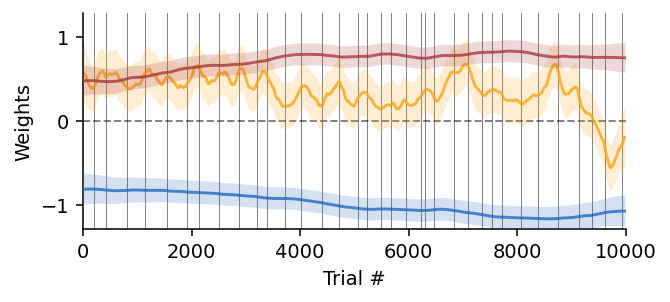

In [28]:
fig = psy.plot_weights(wMode, weights, days=new_D["dayLength"], errorbar=hess_info["W_std"])

We can also generate two additional plots with useful information: 

1) A performance plot, tracking the animal's task accuracy, smoothed over trials

2) A bias plot, tracking the animal's choice bias, smoothed over trials

Both of these plots will calculate their respective values directly from the data, with 2SD error bars.

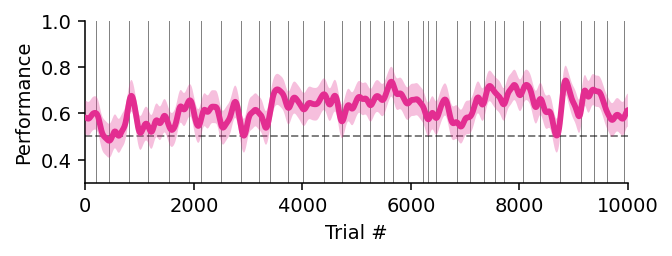

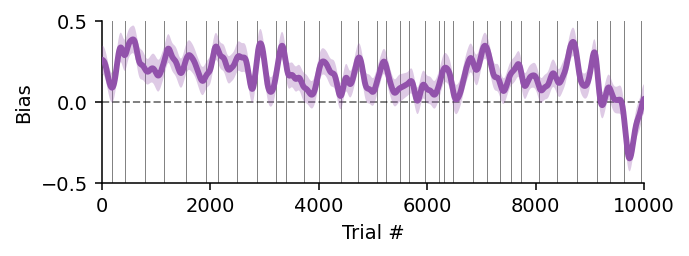

In [29]:
fig_perf = psy.plot_performance(new_D)
fig_bias = psy.plot_bias(new_D)

---
### Cross-validation

The performance and bias plots above use the data directly to plot the *empirical* acuracy and bias of the animal. We can use our model to make predictions about the animal's accuracy and bias using the weight trajectories found by the model, to see if there is agreement. However, to make true predictions, we need to make predictions on trials that were held-out from the fitting procedure.

We can do this using the built-in cross-validation functions `crossValidate`. This is also useful if you'd like to compare different models via cross-validated log-likelihood, rather than approximate model evidence.

Similar to `hyperOpt`, `crossValidate` receives the same inputs as well an additional input `F`, which controls the number of folds in the cross-validation procedure (note that `F` must cleanly divide the number of trials in the dataset `N` -- the `trim` function can be used to make this work). `crossValidate` will then divide the dataset into `F` training and testing datasets, fitting each of the `F` training data sets. It will return `xval_logli`, the total cross-validated log-likelihood of the `F` test sets, as well `xval_pL`, the cross-validated $P(y=0)$ for each trial.

_Note: Since we're fitting `F` models, this can be fairly time consuming. This particular example should take about 10 minutes._

In [30]:
xval_logli, xval_pL = psy.crossValidate(new_D, hyper, weights, optList, F=10, seed=41)

Running xval fold 10 of 10

Using the cross-validated prediction that the animal will go Left on each trial, `xval_pL`, we can overlay the plots of the empirical performance and bias above with a line showing the model's prediction. Fortunately, we see a close agreement!

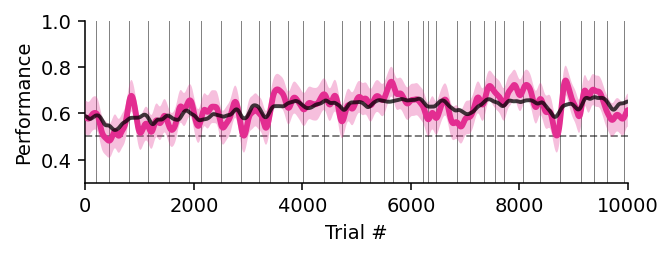

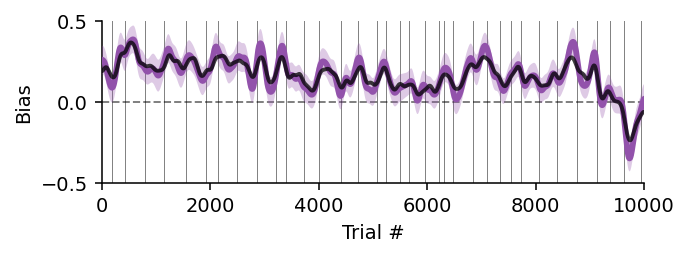

In [31]:
fig_perf_xval = psy.plot_performance(new_D, xval_pL=xval_pL)
fig_bias_xval = psy.plot_bias(new_D, xval_pL=xval_pL)

---
## End of Tutorial

Please post any questions to the github, and thanks for using Psytrack!